# Forecasting the outflow of customers in the hotel chain

# Description of the project

The client of this research is a hotel chain.


To attract customers, this hotel chain has added to its website the ability to book a room without prepayment. However, if the customer cancelled the reservation, the company suffered losses. The hotel staff could, for example, buy groceries for the arrival of a guest or simply not have time to find another customer.


To solve this problem, you need to develop a system that predicts the cancellation of the reservation. If the model shows that the reservation will be cancelled, the client is invited to make a deposit. The deposit amount is 80% of the room rate for one day and the cost of a one—time cleaning. The money will be debited from the customer's account if they cancel the reservation anyway.

# Business metrics and other data

The main business metric for any hotel chain is its profit. The profit of the hotel is the difference between the cost of a room for all nights and the cost of maintenance: both during the preparation of the room and during the stay of the guest. 


The hotel has several types of rooms. Depending on the type of room, the cost per night is assigned. There are also cleaning costs. If the client has rented a room for a long time, then they are cleaned every two days. 


The cost of the hotel rooms:


Category A: 1,000 per night, one—time service — 400;
Category B: per night — 800, one—time service - 350;
Category C: per night — 600, one—time service - 350;
Category D: per night — 550, one—time service - 150;
Category E: 500 per night, one—time service — 150;
Category F: per night — 450, one—time service - 150;
Category G: 350 per night, one—time service — 150.


The hotel's pricing policy uses seasonal coefficients: in spring and autumn prices increase by 20%, in summer — by 40%.
The hotel's losses in case of cancellation of the room reservation are the cost of one cleaning and one night, taking into account the seasonal coefficient.


The budget for the development of the forecasting system is 400,000. At the same time, it should be taken into account that the implementation of the model should pay off during the test period. Development costs should be less than the revenue that the system will bring to the company.

### Step 1. Open the data files

#### Installing the necessary libraries

In [ ]:
pip install shap==0.42.0

#### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import phik
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns
import shap
import time
import warnings

from phik import report
from sklearn import tree
from tqdm import tqdm

from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Set options for jupyter notebook

In [2]:
pyo.init_notebook_mode()
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

We read the files and save them to the train and test variables

Let's print the first 5 lines of each dataframe

In [4]:
train.head()

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   
3   3            0        9.0               2015               July   
4   4            1       85.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0     0.0   
2                        0                     2     2.0       0.0     0.0   
3                        0                     2     2.0       0.0     0.0   
4                        0                     3     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            GBR               Direct                  0   
1  BB            GBR                TA/TO                  0   
2  BB            PRT               Direct                  0   
3  FB            PRT               Direct                  0   
4  BB            PRT                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   C                  
3                       0                               0   C                  
4                       0                               0   A                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1                0                     0     Transient   
2                0                     0     Transient   
3                0                     0     Transient   
4                0                     0     Transient   

   required_car_parking_spaces  total_of_special_requests  total_nights  
0                            0                          0             1  
1                            0                          1             2  
2                            0                          0             2  
3                            0                          1             2  
4                            0                          1             3

In [5]:
test.head()

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  6086            1       74.0               2017            January   
1  6087            1       62.0               2017            January   
2  6088            1       62.0               2017            January   
3  6089            1       71.0               2017            January   
4  6090            1      172.0               2017            January   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     0     2.0       0.0     0.0   
1                        2                     2     2.0       0.0     0.0   
2                        2                     2     2.0       0.0     0.0   
3                        2                     2     1.0       0.0     0.0   
4                        2                     5     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            PRT                TA/TO                  0   
1  BB            AUT                TA/TO                  0   
2  BB            AUT                TA/TO                  0   
3  BB            PRT                TA/TO                  0   
4  BB            BEL                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   A                  
3                       0                               0   A                  
4                       0                               0   A                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1                0                     0     Transient   
2                0                     0     Transient   
3                0                     0     Transient   
4                0                     0     Transient   

   required_car_parking_spaces  total_of_special_requests  total_nights  
0                            0                          0             1  
1                            0                          1             4  
2                            0                          1             4  
3                            0                          1             4  
4                            0                          0             7

### Step 2. Preprocessing and exploratory data analysis

Let's output general information about each dataframe

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Let's check the proportion of the test sample

In [8]:
len(test) / (len(test) + len(train)) * 100

33.19507174240329

Creating histograms for each dataframe

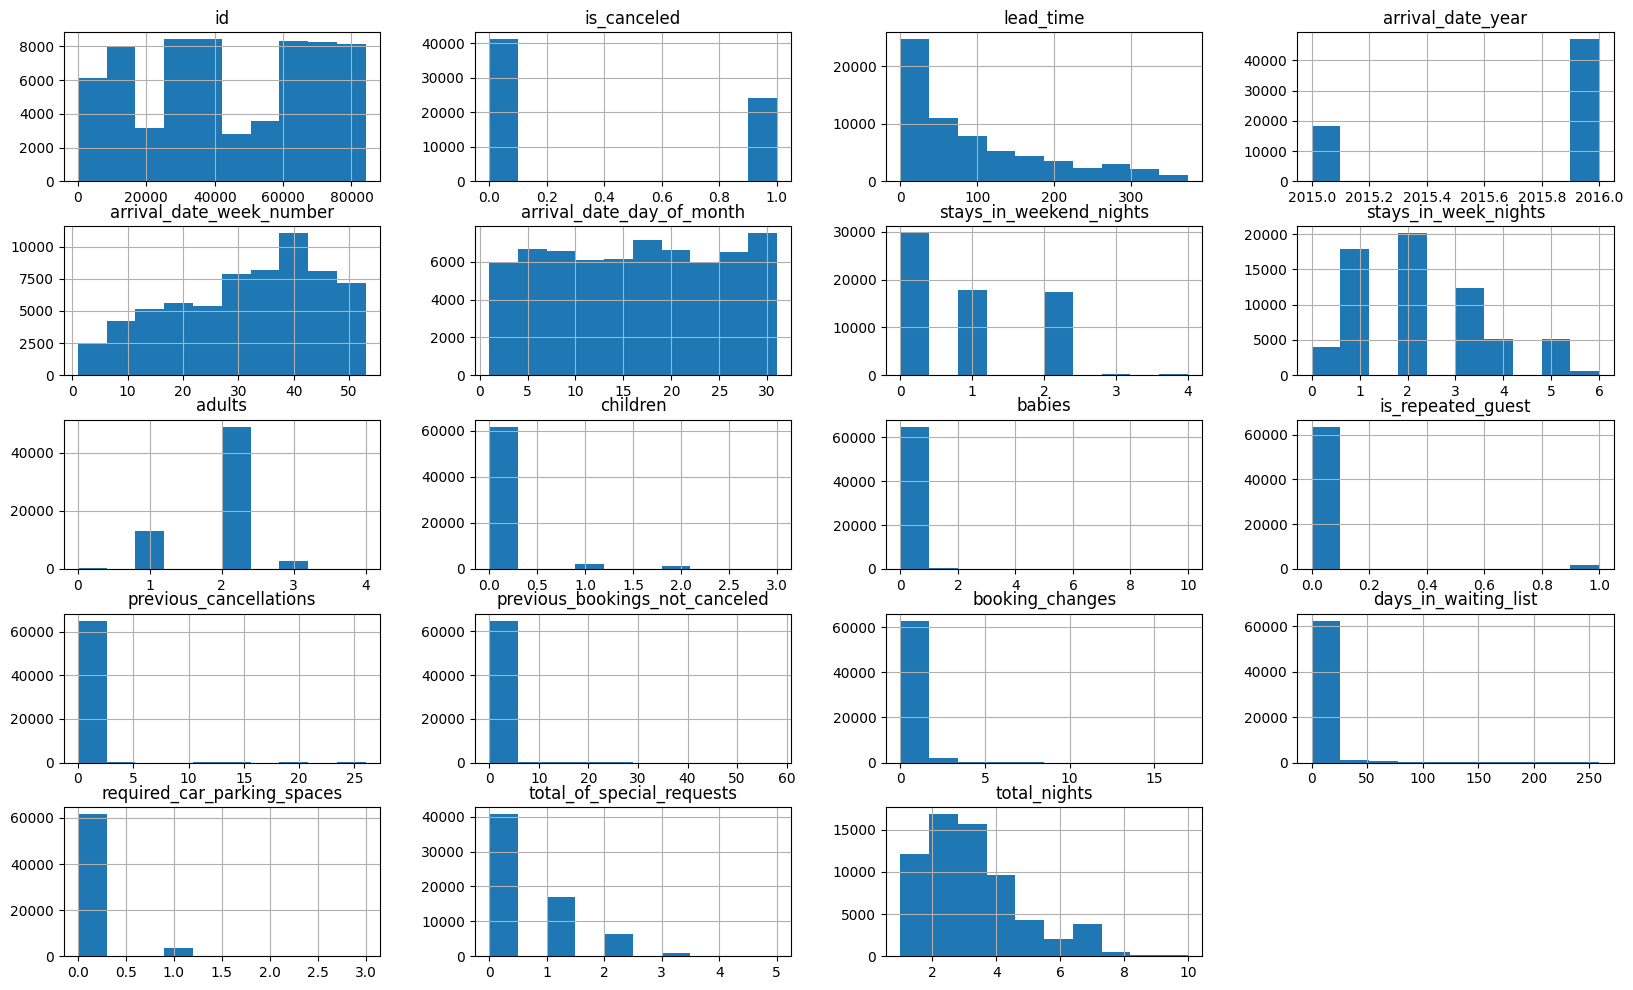

In [9]:
train.loc[:, (train.dtypes == np.float64) | (train.dtypes == np.int64)].hist(figsize=(20, 12))
plt.show()

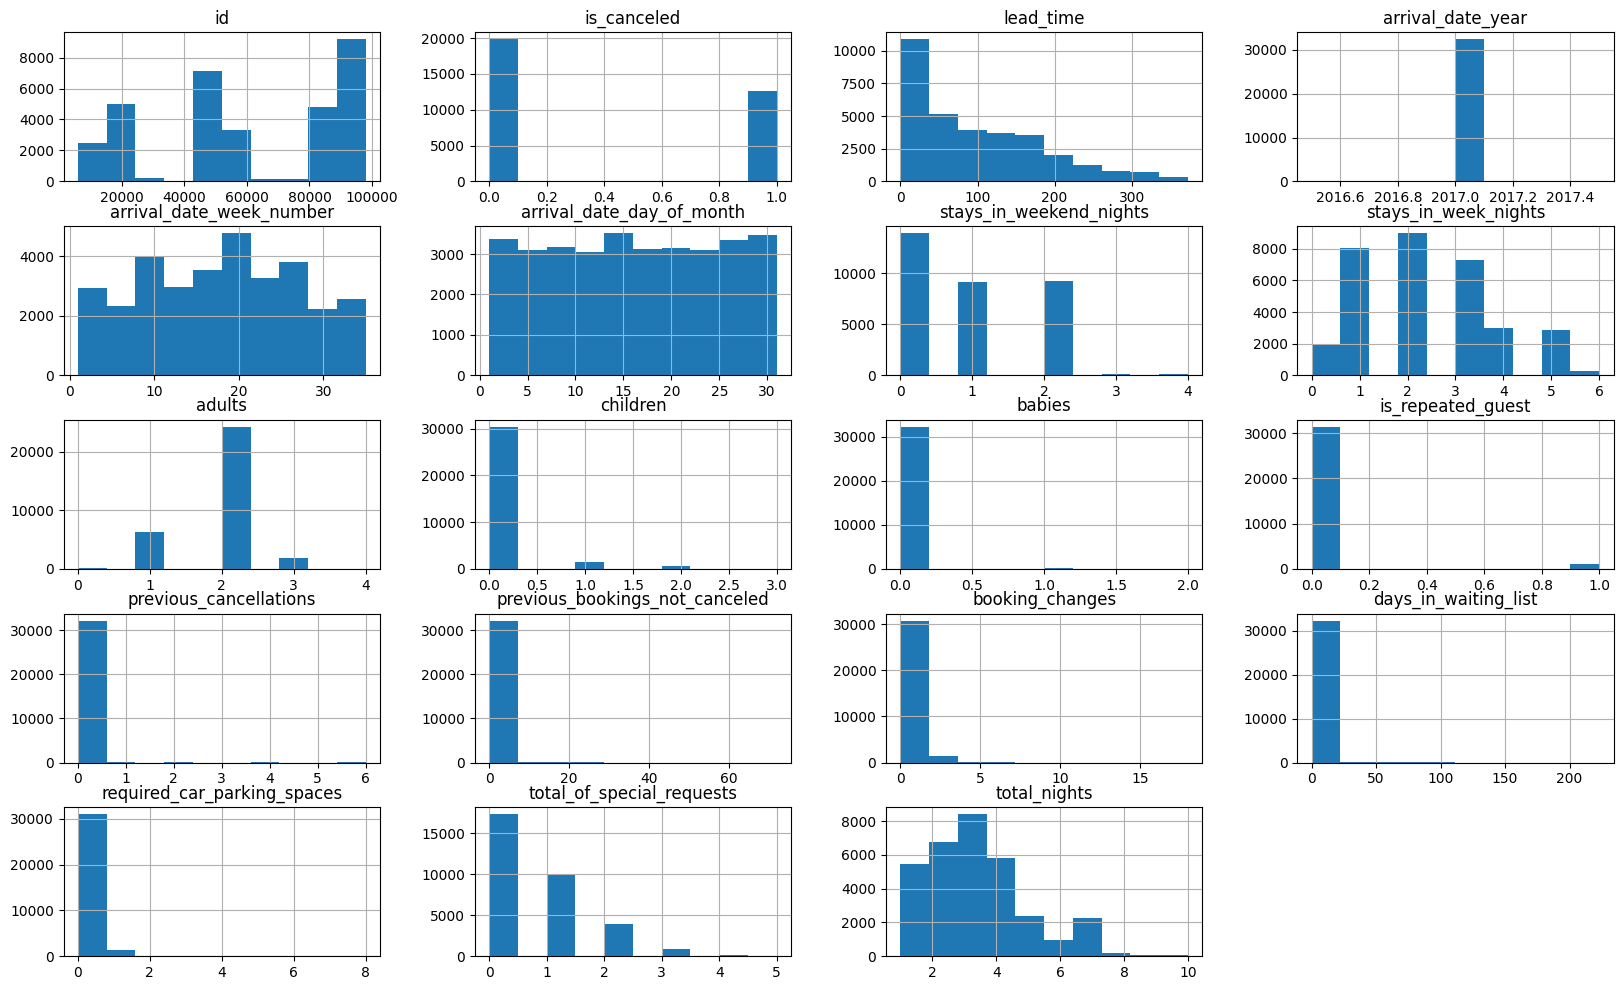

In [10]:
test.loc[:, (test.dtypes == np.float64) | (test.dtypes == np.int64)].hist(figsize=(20, 12))
plt.show()

The data in the babies column looks suspicious. Let's check how the data is distributed by the number of children

In [11]:
train['babies'].value_counts()

babies
0.0     64777
1.0       447
2.0         3
10.0        1
9.0         1
Name: count, dtype: int64

In [12]:
test['babies'].value_counts()

babies
0.0    32237
1.0      171
2.0        4
Name: count, dtype: int64

Let's add a new has_babies column, which will talk about whether there are children or not

In [13]:
train['has_babies'] = train['babies']
train.loc[train['has_babies'] > 0, 'has_babies'] = 1
train['has_babies'] = train['has_babies'].astype('int')

Let's check the new column

In [14]:
train['has_babies'].value_counts()

has_babies
0    64777
1      452
Name: count, dtype: int64

Let's do the same on the test dataframe

In [15]:
test['has_babies'] = test['babies']
test.loc[test['has_babies'] > 0, 'has_babies'] = 1
test['has_babies'] = test['has_babies'].astype('int')

In [16]:
test['has_babies'].value_counts()

has_babies
0    32237
1      175
Name: count, dtype: int64

Let's add a new has_child column, where we'll do the same as for the has_babies column

In [17]:
train['children'].value_counts()

children
0.0    61712
1.0     2165
2.0     1336
3.0       16
Name: count, dtype: int64

In [18]:
train['has_child'] = train['children']
train.loc[train['has_child'] > 0, 'has_child'] = 1
train['has_child'] = train['has_child'].astype('int')

Now for the test

In [19]:
test['has_child'] = test['children']
test.loc[test['has_child'] > 0, 'has_child'] = 1
test['has_child'] = test['has_child'].astype('int')

In [20]:
test['has_child'].value_counts()

has_child
0    30360
1     2052
Name: count, dtype: int64

We will also add a column with the sum of infants, children and adults

In [21]:
train['overal_num_of_customers'] = train['babies'] + train['children'] + train['adults']

And for the test

In [22]:
test['overal_num_of_customers'] = test['babies'] + test['children'] + test['adults']

Let's check the distribution

In [23]:
test['overal_num_of_customers'].value_counts()

overal_num_of_customers
2.0    22452
1.0     6131
3.0     3197
4.0      616
5.0        9
0.0        7
Name: count, dtype: int64

In [24]:
train['overal_num_of_customers'].value_counts()

overal_num_of_customers
2.0     45729
1.0     13019
3.0      5217
4.0      1230
5.0        17
0.0        15
12.0        1
10.0        1
Name: count, dtype: int64

It is immediately clear that there are anomalies with 0 people per check-in. There is very little such data, it is easier to delete them

In [25]:
train = train[train['overal_num_of_customers'] > 0]
test = test[test['overal_num_of_customers'] > 0]

Let's check the distribution of categorical features using barlpot. First for train

In [26]:
col_obj = train.loc[:, (train.dtypes == object)].columns
col_obj

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')

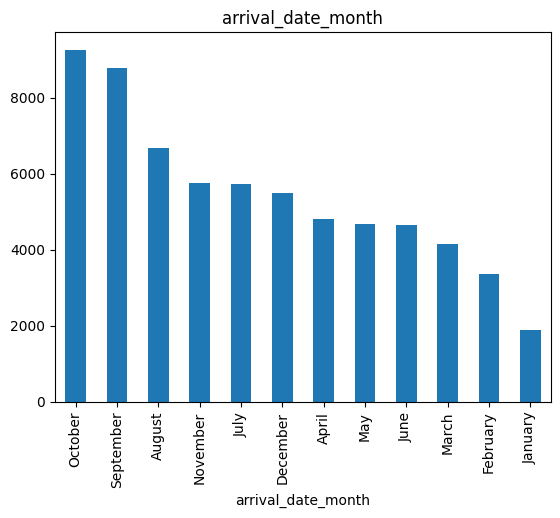

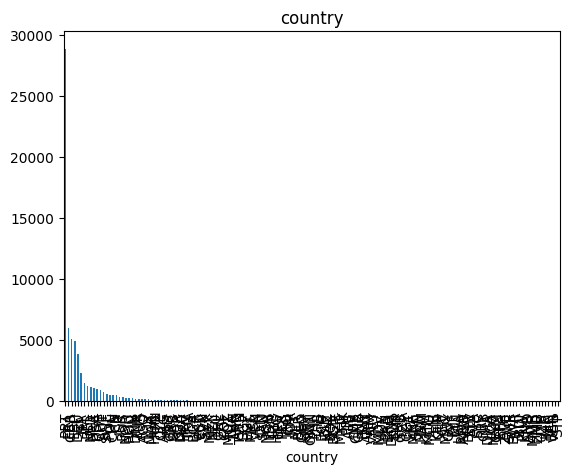

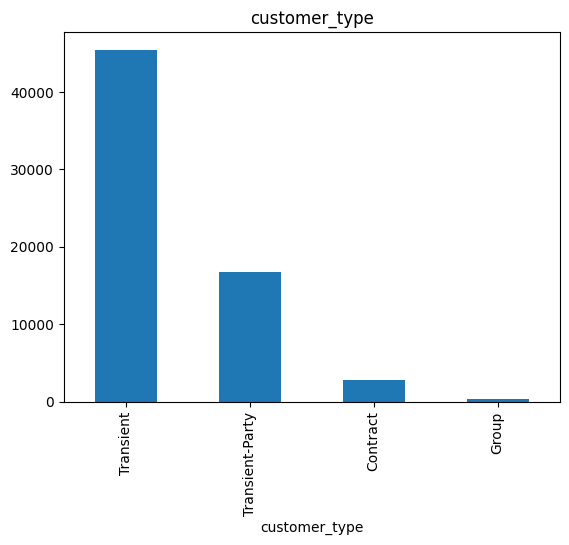

In [27]:
for i in col_obj:
    train[i].value_counts().plot.bar()
    plt.title(i)
    plt.show()

Now for the test

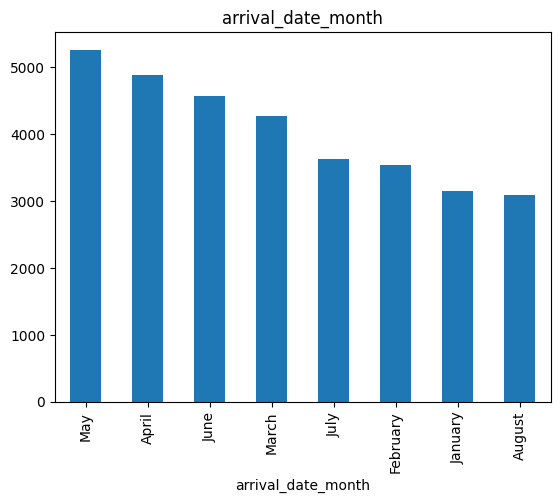

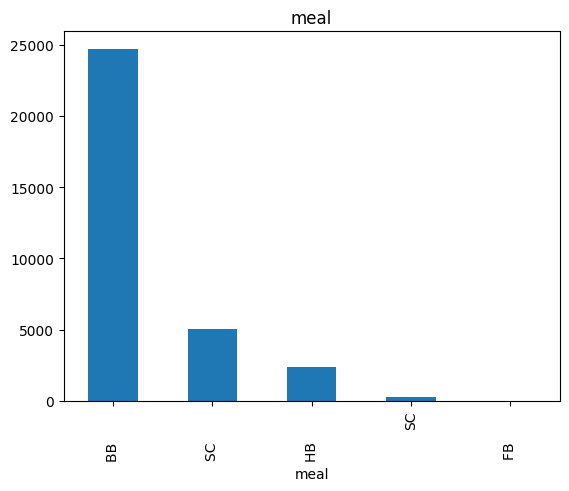

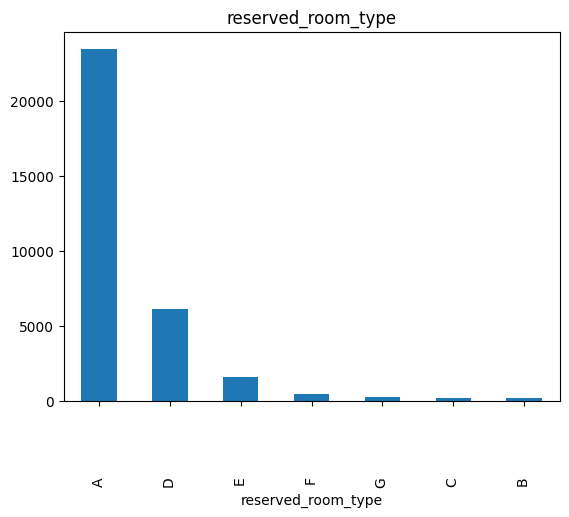

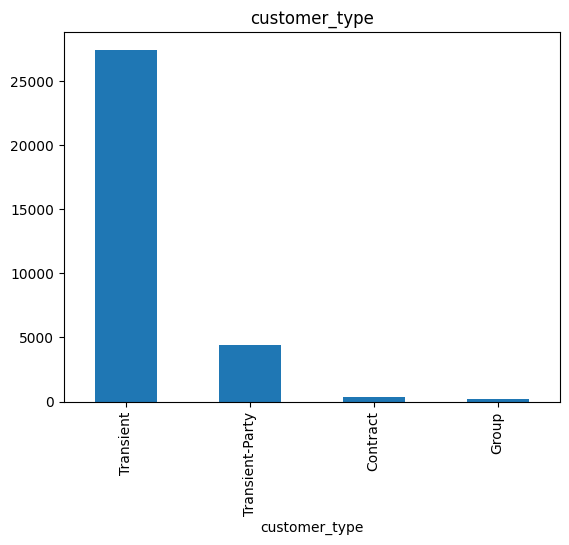

In [28]:
for i in col_obj:
    test[i].value_counts().plot.bar()
    plt.title(i)
    plt.show()

Let's check the dependencies between variables using the pil library

In [29]:
phik_overview = train.phik_matrix()
#phik_overview.round(2)

interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'has_babies', 'has_child', 'overal_num_of_customers']


We will output only those cases where the correlations are higher than 0.5

In [30]:
plot_correlation_matrix(phik_overview[phik_overview > 0.5].values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

We see a high correlation between the id and our target (is_canceled). This is clearly not logical, since id is a "random" value. Let's remove it from the predictors

For some reason, there are no correlation values with arrival_date_year. Let's check the values in this column

In [31]:
train['arrival_date_year'].value_counts()

arrival_date_year
2016    46887
2015    18327
Name: count, dtype: int64

Well, okay. There are two unique values, but I think you can't use the year as a predictor. Since the task is to predict those people who will cancel the reservation in the future.

Let's also check the relationship between citizenship and cancellation of the reservation

In [32]:
t = train.groupby(['country']).agg({'is_canceled': ['sum', 'count']})
t.columns = ['sum', 'count']
t['ratio'] = t['sum'] / t['count']
t[t['ratio'] == 1].sort_values(['ratio', 'sum'], ascending=False)

sum  count  ratio
country                   
HKG       16     16    1.0
TJK        8      8    1.0
JEY        5      5    1.0
GGY        3      3    1.0
GLP        2      2    1.0
KHM        2      2    1.0
MAC        2      2    1.0
AND        1      1    1.0
BEN        1      1    1.0
HND        1      1    1.0
IMN        1      1    1.0
NIC        1      1    1.0
UZB        1      1    1.0
VGB        1      1    1.0
ZMB        1      1    1.0

Let's check, for example, customers from the HKG country. Perhaps this is the cancellation of a group of visitors who arrived at the same time and could be related to each other. In this regard, it could be considered one cancellation and discard the hypothesis that customers from this country always cancel their reservation

In [33]:
train[train['country'] == 'HKG']

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
4426    4476            1       94.0               2016               June   
25693  33633            1       51.0               2016              April   
29318  37258            1       77.0               2016               June   
29394  37334            1       77.0               2016               June   
29566  37506            1      145.0               2016               June   
29596  37536            1        6.0               2016               June   
29637  37577            1       60.0               2016               June   
29941  37881            1       14.0               2016               July   
30010  37950            1       69.0               2016               July   
30404  38344            1       43.0               2016               July   
31040  38980            1      122.0               2016             August   
33327  41267            1      207.0               2016            October   
33328  41268            1      207.0               2016            October   
33329  41269            1      207.0               2016            October   
33330  41270            1      207.0               2016            October   
36116  44056            1       74.0               2016           December   

       arrival_date_week_number  arrival_date_day_of_month  \
4426                         27                         26   
25693                        16                         14   
29318                        25                         17   
29394                        25                         17   
29566                        26                         21   
29596                        26                         23   
29637                        26                         23   
29941                        27                          1   
30010                        27                          2   
30404                        29                         14   
31040                        32                          6   
33327                        41                          4   
33328                        41                          4   
33329                        41                          4   
33330                        41                          4   
36116                        49                          2   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  \
4426                         2                     3     1.0       0.0   
25693                        0                     2     1.0       0.0   
29318                        0                     2     2.0       0.0   
29394                        0                     2     2.0       0.0   
29566                        0                     2     2.0       0.0   
29596                        0                     1     1.0       0.0   
29637                        0                     1     3.0       0.0   
29941                        0                     1     2.0       0.0   
30010                        0                     1     3.0       0.0   
30404                        0                     1     3.0       0.0   
31040                        2                     2     2.0       0.0   
33327                        0                     1     2.0       0.0   
33328                        0                     1     2.0       0.0   
33329                        0                     1     2.0       0.0   
33330                        0                     1     2.0       0.0   
36116                        1                     2     2.0       0.0   

       babies       meal country distribution_channel  is_repeated_guest  \
4426      0.0  BB            HKG                TA/TO                  0   
25693     0.0  BB            HKG                TA/TO                  0   
29318     0.0  SC            HKG                TA/TO                  0   
29394     0.0  SC            HKG                TA/TO            

Of course there are groups, but there are several of them. The above hypothesis can be rejected

Creating a list with the most common countries

In [34]:
list_of_top_countries = list(train['country'].value_counts().head(15).index)
list_of_top_countries

['PRT',
 'FRA',
 'GBR',
 'ESP',
 'DEU',
 'ITA',
 'IRL',
 'BEL',
 'NLD',
 'BRA',
 'USA',
 'CHE',
 'AUT',
 'SWE',
 'POL']

Setting the function to convert the country column

In [35]:
def top_countries(DataFrame):
    DataFrame['top_countries'] = 'other'
    for country in list_of_top_countries:
        DataFrame.loc[DataFrame['country'] == country, 'top_countries'] = country

Transforming the data in a training data frame

In [36]:
top_countries(train)
train['top_countries'].value_counts()

top_countries
PRT      28825
FRA       5973
other     5581
GBR       5109
ESP       4899
DEU       3887
ITA       2327
IRL       1445
BEL       1245
NLD       1166
BRA       1087
USA       1008
CHE        872
AUT        716
SWE        543
POL        531
Name: count, dtype: int64

Transforming citizenship data for a test dataframe

In [37]:
top_countries(test)
test['top_countries'].value_counts()

top_countries
PRT      9885
GBR      3926
other    3752
FRA      3477
DEU      2378
ESP      1932
ITA      1153
IRL      1060
BEL       882
BRA       881
USA       774
NLD       709
CHE       601
AUT       439
SWE       317
POL       239
Name: count, dtype: int64

Let's read the dataframe with country data

In [38]:
countries = pd.read_csv('https://www.artlebedev.ru/country-list/tab/', sep='\t')
countries.head()

name                fullname     english alpha2 alpha3  iso  \
0      Абхазия      Республика Абхазия    Abkhazia     AB    ABH  895   
1    Австралия                     NaN   Australia     AU    AUS   36   
2      Австрия  Австрийская Республика     Austria     AT    AUT   40   
3  Азербайджан  Республика Азербайджан  Azerbaijan     AZ    AZE   31   
4      Албания      Республика Албания     Albania     AL    ALB    8   

  location            location-precise  
0     Азия                  Закавказье  
1  Океания  Австралия и Новая Зеландия  
2   Европа             Западная Европа  
3     Азия               Западная Азия  
4   Европа                Южная Европа

Let's see what happens if we remove duplicates from the training dataframe without taking into account the id column

In [39]:
len(train) - len(train.drop('id', axis=1).drop_duplicates())

21377

The difference in sample size is the number of duplicates deleted.

In [40]:
train = train.drop('id', axis=1).drop_duplicates()
test = test.drop('id', axis=1).drop_duplicates()

In [41]:
len(test) - len(test.drop_duplicates())

0

There are duplicates in the test version too, but I think it is impossible to remove outliers from it. Since, according to the condition of the project, profit should be counted on the entire test sample

Let's check the required_car_parking_spaces column

In [42]:
train['required_car_parking_spaces'].value_counts()

required_car_parking_spaces
0    40239
1     3586
2       11
3        1
Name: count, dtype: int64

Let's change the values in the column to binary classification. Parking spaces are required (1) or not (0)

In [43]:
train['car_parking_binary'] = train['required_car_parking_spaces'].apply(lambda x: 0 if x<1 else 1)

In [44]:
test['car_parking_binary'] = test['required_car_parking_spaces'].apply(lambda x: 0 if x<1 else 1)

Let's check if there are any attempts to check into rooms without adults. There are 149 such cases. Let's delete them

In [45]:
train = train.drop(train[((train['children'] > 0) | (train['babies'] > 0)) & (train['adults'] < 1)].index, axis=0)

Let's do the same for the test sample. There are 76 similar cases

In [46]:
test = test.drop(test[((test['children'] > 0) | (test['babies'] > 0)) & (test['adults'] < 1)].index, axis=0)

### Step 3. Formulation of an ML task based on a business task

#### Profit calculation

Let's start calculating the profit by determining how the payment for accommodation for the client will be calculated. To do this, we will create a dictionary, where the key will be the room category, and the value will be a list with the cost of living and cleaning the room

In [47]:
dict_of_cost = {'A': [1000, 400],
                'B': [800, 350],
                'C': [600, 350],
                'D': [550, 150],
                'E': [500, 150],
                'F': [450, 150], 
                'G': [350, 150]}

Let's divide the months into seasons

In [48]:
w_months = ['December', 'January', 'February']
sp_months = ['March', 'April', 'May']
sum_months = ['June', 'July', 'August']
o_months = ['September', 'October', 'November']

I found that in the column with the reserved_room_type room type, the designation has extra spaces. Let's delete them

In [49]:
train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [50]:
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
test['reserved_room_type'] = test['reserved_room_type'].str.strip()

In [51]:
for col in col_obj:
    train[col].str.strip()
    test[col].str.strip()

In [52]:
train['distribution_channel'].value_counts()

distribution_channel
TA/TO        35044
Direct        5800
Corporate     2754
GDS             90
Name: count, dtype: int64

There are no hidden duplicates in this column

Let's set the profit calculation function

In [53]:
def profit(DataFrame):
    """
    This function calculates the profit from each client depending on the season, the number of cleanings, 
    the type of room and the total number of nights. The function takes a dataframe as an argument.
    """
    # using previously created lists with months for each season, we determine the coefficient 
    # of increase in the cost of services
    if DataFrame['arrival_date_month'] in w_months:
        season_coef = 1
    elif (DataFrame['arrival_date_month'] in sp_months) or (DataFrame['arrival_date_month'] in o_months):
        season_coef = 1.2
    elif DataFrame['arrival_date_month'] in sum_months:
        season_coef = 1.4
    # if the reservation is canceled, then we sum up the cost of one night in a certain type of room and 
    # the cost of one cleaning, adjusted for the season with a negative value
    if DataFrame['is_canceled'] == 1:
        return -(dict_of_cost[DataFrame['reserved_room_type']][0] * season_coef + dict_of_cost[DataFrame['reserved_room_type']][1])
    # if the reservation has not been canceled, then we subtract the cost of cleaning from the cost of each 
    # night in a certain type of room, after which we multiply by the seasonal coefficient

    # The number of cleanups is calculated as follows: divide the number of nights by 2 and round it up to the whole
    elif DataFrame['is_canceled'] == 0:
        return (dict_of_cost[DataFrame['reserved_room_type']][0] * DataFrame['total_nights'] * season_coef - \
                (round(DataFrame['total_nights'] + 1) // 2) * dict_of_cost[DataFrame['reserved_room_type']][1]) \
                

Applying the profit function to the train dataframe

In [54]:
train['profit'] = train.apply(profit, axis=1)

In [55]:
train.head()

is_canceled  lead_time  arrival_date_year arrival_date_month  \
0            0        7.0               2015               July   
1            0       14.0               2015               July   
2            0        0.0               2015               July   
3            0        9.0               2015               July   
4            1       85.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0     0.0   
2                        0                     2     2.0       0.0     0.0   
3                        0                     2     2.0       0.0     0.0   
4                        0                     3     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            GBR               Direct                  0   
1  BB            GBR                TA/TO                  0   
2  BB            PRT               Direct                  0   
3  FB            PRT               Direct                  0   
4  BB            PRT                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  A   
1                       0                               0                  A   
2                       0                               0                  C   
3                       0                               0                  C   
4                       0                               0                  A   

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1                0                     0     Transient   
2                0                     0     Transient   
3                0                     0     Transient   
4                0                     0     Transient   

   required_car_parking_spaces  total_of_special_requests  total_nights  \
0                            0                          0             1   
1                            0                          1             2   
2                            0                          0             2   
3                            0                          1             2   
4                            0                          1             3   

   has_babies  has_child  overal_num_of_customers top_countries  \
0           0          0                      1.0           GBR   
1           0          0                      2.0           GBR   
2           0          0                      2.0           PRT   
3           0          0                      2.0           PRT   
4           0          0                      2.0           PRT   

   car_parking_binary  profit  
0                   0  1000.0  
1                   0  2400.0  
2                   0  1330.0  
3                   0  1330.0  
4                   0 -1800.0

Let's calculate how much profit the hotel chain receives on the training dataframe in millions of rubles.

In [56]:
train.profit.sum() / 1000000

70.50592

Let's calculate the total losses due to cancellation of the reservation, million rubles.

In [57]:
train[train['profit'] < 0]['profit'].sum() / 1000000

-15.12101

Let's apply the profit function to the test dataframe

In [58]:
test['profit'] = test.apply(profit, axis=1)

Let's calculate the profit in the test dataframe, million rubles.

In [59]:
test.profit.sum() / 1000000

34.79711

Let's calculate the total losses due to cancellation of the reservation, million rubles.

In [60]:
test[test['profit'] < 0]['profit'].sum() / 1000000

-10.53477

We can say that in the test sample, we actually lost 18 million rubles due to the cancellation of the reservation

Now let's calculate the benefit using bootstrap to calculate the 95% confidence interval

In [61]:
state = np.random.RandomState(12345)
# creating an empty list in which we will save the values of potential profit
values_basic = []
# creating a loop with 1000 repetitions
for i in range(1000):
    # for each iteration in the loop, using the sample method, we pull back the same number 
    # of values as in the original dataframe
    subsample = test['profit'].sample(frac=1, 
                                      replace=True, 
                                      random_state=state)
    # calculating the total profit from all visitors and add it to the list
    values_basic.append(subsample.sum())
    # transforming the list into a series
values_basic = pd.Series(values_basic)
# we find the average profit value
mean_basic = values_basic.mean()
print("Average revenue, million rubles:", round(mean_basic / 1000000, 2))
# we determine the upper and lower limits for the 95% confidence interval
lower_basic = values_basic.quantile(0.025)
upper_basic = values_basic.quantile(0.975)
print("The confidence interval of profit (million rubles): from", 
      round(lower_basic / 1000000, 2), 
      "till",  round(upper_basic / 1000000, 2))

Average revenue, million rubles: 34.81
The confidence interval of profit (million rubles): from 34.08 till 35.52


We are creating a results dataframe in which we will transfer profit values for different models

In [62]:
results = pd.DataFrame({'basic': values_basic})
results

basic
0    35108510.0
1    35043740.0
2    34599550.0
3    35178040.0
4    35082530.0
..          ...
995  34533490.0
996  35620970.0
997  34808290.0
998  34831310.0
999  34848090.0

[1000 rows x 1 columns]

### Step 4. Development of the ML model

#### Removing unnecessary features

Creating a list of unnecessary features

In [63]:
train['children'].value_counts()

children
0.0    40456
1.0     2058
2.0     1166
3.0        8
Name: count, dtype: int64

In [64]:
list_of_extra_features = [
                          'is_canceled', # target
                          'profit', # based on target
                          'arrival_date_year', # the year cannot be taken into account for future data in the model
                          'stays_in_weekend_nights', # counted in total_nights
                          'stays_in_week_nights', # counted in total_nights
                          'arrival_date_week_number', # correlates with the month
                          'babies', # replaced it with a binary classification
                          'country', # replaced it with a binary classification
                          'required_car_parking_spaces', # replaced it with a binary classification
                          'children', # it is an integral part of synthetic features
                          'babies', # it is an integral part of synthetic features
                          'adults', # it is an integral part of synthetic features
                          'has_child' # strongly correlates with the total number of customers
                         ]

Deleting extra features

In [65]:
features_train = train.drop(list_of_extra_features, axis=1)
features_test = test.drop(list_of_extra_features, axis=1)

In [66]:
features_train

lead_time arrival_date_month  arrival_date_day_of_month       meal  \
0            7.0               July                          1  BB          
1           14.0               July                          1  BB          
2            0.0               July                          1  BB          
3            9.0               July                          1  FB          
4           85.0               July                          1  BB          
...          ...                ...                        ...        ...   
65224       23.0           December                         30  BB          
65225       53.0           December                         31  HB          
65226        7.0           December                         31  BB          
65227       17.0           December                         30  SC          
65228      107.0           December                         31  BB          

      distribution_channel  is_repeated_guest  previous_cancellations  \
0                   Direct                  0                       0   
1                    TA/TO                  0                       0   
2                   Direct                  0                       0   
3                   Direct                  0                       0   
4                    TA/TO                  0                       0   
...                    ...                ...                     ...   
65224                TA/TO                  0                       0   
65225                TA/TO                  0                       0   
65226                TA/TO                  0                       0   
65227                TA/TO                  0                       0   
65228                TA/TO                  0                       0   

       previous_bookings_not_canceled reserved_room_type  booking_changes  \
0                                   0                  A                0   
1                                   0                  A                0   
2                                   0                  C                0   
3                                   0                  C                0   
4                                   0                  A                0   
...                               ...                ...              ...   
65224                               0                  D                0   
65225                               0                  D                0   
65226                               0                  D                0   
65227                               0                  A                0   
65228                               0                  A                0   

       days_in_waiting_list customer_type  total_of_special_requests  \
0                         0     Transient                          0   
1                         0     Transient                          1   
2                         0     Transient                          0   
3                         0     Transient                          1   
4                         0     Transient                          1   
...                     ...           ...                        ...   
65224                     0     Transient                          2   
65225                     0     Transient                          3   
65226                     0     Transient                          1   
65227                     0     Transient                          1   
65228                     0     Transient                          0   

       total_nights  has_babies  overal_num_of_customers top_countries  \
0                 1           0                      1.0           GBR   
1                 2           0                      2.0           GBR   
2                 2           0                      2.0           PRT   
3                 2           0                      2.0           PRT   
4                 3           0              

In [67]:
phik_overview = features_train.phik_matrix()
#phik_overview.round(2)

interval columns not set, guessing: ['lead_time', 'arrival_date_day_of_month', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'total_nights', 'has_babies', 'overal_num_of_customers', 'car_parking_binary']


In [68]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

#### We have attributes that need to be transformed from the object class to numeric values. Let's use OHE for this

In [69]:
col_obj

Index(['arrival_date_month', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'customer_type'],
      dtype='object')

In [70]:
features_train

lead_time arrival_date_month  arrival_date_day_of_month       meal  \
0            7.0               July                          1  BB          
1           14.0               July                          1  BB          
2            0.0               July                          1  BB          
3            9.0               July                          1  FB          
4           85.0               July                          1  BB          
...          ...                ...                        ...        ...   
65224       23.0           December                         30  BB          
65225       53.0           December                         31  HB          
65226        7.0           December                         31  BB          
65227       17.0           December                         30  SC          
65228      107.0           December                         31  BB          

      distribution_channel  is_repeated_guest  previous_cancellations  \
0                   Direct                  0                       0   
1                    TA/TO                  0                       0   
2                   Direct                  0                       0   
3                   Direct                  0                       0   
4                    TA/TO                  0                       0   
...                    ...                ...                     ...   
65224                TA/TO                  0                       0   
65225                TA/TO                  0                       0   
65226                TA/TO                  0                       0   
65227                TA/TO                  0                       0   
65228                TA/TO                  0                       0   

       previous_bookings_not_canceled reserved_room_type  booking_changes  \
0                                   0                  A                0   
1                                   0                  A                0   
2                                   0                  C                0   
3                                   0                  C                0   
4                                   0                  A                0   
...                               ...                ...              ...   
65224                               0                  D                0   
65225                               0                  D                0   
65226                               0                  D                0   
65227                               0                  A                0   
65228                               0                  A                0   

       days_in_waiting_list customer_type  total_of_special_requests  \
0                         0     Transient                          0   
1                         0     Transient                          1   
2                         0     Transient                          0   
3                         0     Transient                          1   
4                         0     Transient                          1   
...                     ...           ...                        ...   
65224                     0     Transient                          2   
65225                     0     Transient                          3   
65226                     0     Transient                          1   
65227                     0     Transient                          1   
65228                     0     Transient                          0   

       total_nights  has_babies  overal_num_of_customers top_countries  \
0                 1           0                      1.0           GBR   
1                 2           0                      2.0           GBR   
2                 2           0                      2.0           PRT   
3                 2           0                      2.0           PRT   
4                 3           0              

In [71]:
# passing the names of the features for conversion from the object type to the features_categorical list
features_categorical = list(set(list(col_obj)) - set(['country']))
# creating the ohe variable, into which we pass the OHE encoder
ohe = OneHotEncoder(drop='first')
# "training" ohe on a combined dataframe
ohe.fit(pd.concat([features_train, features_test], ignore_index=True, sort=False)[list(features_train.loc[:, (features_train.dtypes == object)].columns)])
# setting a function for "learning" dataframes
def features_ohe(ohe_variable, df_features, features_categ):
    """
    The function receives an encoder, a dataframe, 
    and a list of features that need to be encoded.
    """
    # creating a dataframe with transformed data
    transformed_data = ohe_variable.transform(df_features[features_categ]).toarray()
    print("Shape of transformed data:", transformed_data.shape)  # Add this line to print the shape
    
    feature_names = ohe_variable.get_feature_names_out(input_features=features_categ)
    print("Feature names:", feature_names)  # Add this line to print the feature names
    
#    return transformed_data
    
    df_features_ohe = pd.DataFrame(
        data=transformed_data, 
        index=df_features.index,
        columns=feature_names
    )
    # dropping the original features from the original dataframe
    df_features = df_features.drop(features_categ, axis=1)
    # joining the encoded data with the original data frame
    df_features = df_features.join(df_features_ohe)
    return df_features

We encode the dataframes and save them as featers_train_r and features_test_r, where r is the designation for regression models

#### Converting data for training and test data frames for the logistic regression model

In [72]:
features_train_r = features_ohe(ohe, features_train, list(features_train.loc[:, (features_train.dtypes == object)].columns))
features_test_r = features_ohe(ohe, features_test, list(features_test.loc[:, (features_test.dtypes == object)].columns))

Shape of transformed data: (43688, 42)
Feature names: ['arrival_date_month_August' 'arrival_date_month_December'
 'arrival_date_month_February' 'arrival_date_month_January'
 'arrival_date_month_July' 'arrival_date_month_June'
 'arrival_date_month_March' 'arrival_date_month_May'
 'arrival_date_month_November' 'arrival_date_month_October'
 'arrival_date_month_September' 'meal_FB       ' 'meal_HB       '
 'meal_SC' 'meal_SC       ' 'distribution_channel_Direct'
 'distribution_channel_GDS' 'distribution_channel_TA/TO'
 'reserved_room_type_B' 'reserved_room_type_C' 'reserved_room_type_D'
 'reserved_room_type_E' 'reserved_room_type_F' 'reserved_room_type_G'
 'customer_type_Group' 'customer_type_Transient'
 'customer_type_Transient-Party' 'top_countries_BEL' 'top_countries_BRA'
 'top_countries_CHE' 'top_countries_DEU' 'top_countries_ESP'
 'top_countries_FRA' 'top_countries_GBR' 'top_countries_IRL'
 'top_countries_ITA' 'top_countries_NLD' 'top_countries_POL'
 'top_countries_PRT' 'top_countries

In [73]:
features_train_r.head()

lead_time  arrival_date_day_of_month  is_repeated_guest  \
0        7.0                          1                  0   
1       14.0                          1                  0   
2        0.0                          1                  0   
3        9.0                          1                  0   
4       85.0                          1                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                       0                               0                0   
1                       0                               0                0   
2                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   

   days_in_waiting_list  total_of_special_requests  total_nights  has_babies  \
0                     0                          0             1           0   
1                     0                          1             2           0   
2                     0                          0             2           0   
3                     0                          1             2           0   
4                     0                          1             3           0   

   overal_num_of_customers  car_parking_binary  arrival_date_month_August  \
0                      1.0                   0                        0.0   
1                      2.0                   0                        0.0   
2                      2.0                   0                        0.0   
3                      2.0                   0                        0.0   
4                      2.0                   0                        0.0   

   arrival_date_month_December  arrival_date_month_February  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   arrival_date_month_January  arrival_date_month_July  \
0                         0.0                      1.0   
1                         0.0                      1.0   
2                         0.0                      1.0   
3                         0.0                      1.0   
4                         0.0                      1.0   

   arrival_date_month_June  arrival_date_month_March  arrival_date_month_May  \
0                      0.0                       0.0                     0.0   
1                      0.0                       0.0                     0.0   
2                      0.0                       0.0                     0.0   
3                      0.0                       0.0                     0.0   
4                      0.0                       0.0                     0.0   

   arrival_date_month_November  arrival_date_month_October  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   arrival_date_month_September  meal_FB         meal_HB         meal_SC  \
0                           0.0             0.0             0.0      0.0   
1                           0.0             0.0             0.0      0.0   
2                           0.0             0.0             0.0      0.0   
3                           0.0             1.0             0.0      0.0   
4                           0.0             0.0             0.0      0.0   

   meal_SC         distribution_channel_Direct  distribution_channel_GDS  \
0             0.0                          1.0                       0.0   
1             0.0         

In [74]:
features_test_r.head()

lead_time  arrival_date_day_of_month  is_repeated_guest  \
0       74.0                          1                  0   
1       62.0                          1                  0   
3       71.0                          1                  0   
4      172.0                          1                  0   
5       52.0                          1                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                       0                               0                0   
1                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   
5                       0                               0                0   

   days_in_waiting_list  total_of_special_requests  total_nights  has_babies  \
0                     0                          0             1           0   
1                     0                          1             4           0   
3                     0                          1             4           0   
4                     0                          0             7           0   
5                     0                          0             7           0   

   overal_num_of_customers  car_parking_binary  arrival_date_month_August  \
0                      2.0                   0                        0.0   
1                      2.0                   0                        0.0   
3                      1.0                   0                        0.0   
4                      2.0                   0                        0.0   
5                      1.0                   0                        0.0   

   arrival_date_month_December  arrival_date_month_February  \
0                          0.0                          0.0   
1                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   
5                          0.0                          0.0   

   arrival_date_month_January  arrival_date_month_July  \
0                         1.0                      0.0   
1                         1.0                      0.0   
3                         1.0                      0.0   
4                         1.0                      0.0   
5                         1.0                      0.0   

   arrival_date_month_June  arrival_date_month_March  arrival_date_month_May  \
0                      0.0                       0.0                     0.0   
1                      0.0                       0.0                     0.0   
3                      0.0                       0.0                     0.0   
4                      0.0                       0.0                     0.0   
5                      0.0                       0.0                     0.0   

   arrival_date_month_November  arrival_date_month_October  \
0                          0.0                         0.0   
1                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   
5                          0.0                         0.0   

   arrival_date_month_September  meal_FB         meal_HB         meal_SC  \
0                           0.0             0.0             0.0      0.0   
1                           0.0             0.0             0.0      0.0   
3                           0.0             0.0             0.0      0.0   
4                           0.0             0.0             0.0      0.0   
5                           0.0             0.0             0.0      0.0   

   meal_SC         distribution_channel_Direct  distribution_channel_GDS  \
0             0.0                          0.0                       0.0   
1             0.0         

#### Creating final date frames with features and a target

Setting a list with the features that need to be deleted

Setting a target for training and testing

In [75]:
target_train = train['is_canceled']
target_test = test['is_canceled']

#### To assess the quality of the model, we define the baseline by f1

In [76]:
# passing the DummyClassifier to the dummy_clf variable
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
# training the model
dummy_clf.fit(features_train, target_train)
# estimating f1
f1_score(target_test, dummy_clf.predict(features_test))

0.38976044623736245

#### Let's create a logistic regression model

In [77]:
# creating a pipeline, which we pass the logistic regression model and standardization of parameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('logreg', LogisticRegression())
])

# we implement cross-validation using the f1 metric
cv_scores = cross_val_score(pipeline, features_train_r, target_train, cv=5, scoring='f1')
y_pred = cross_val_predict(pipeline, features_train_r, target_train, cv=5)

# we calculate the average value of the metric
print("Average F1:", cv_scores.mean())
# we train the model on a training sample
pipeline = pipeline.fit(features_train_r, target_train)

Average F1: 0.25673370731123757


#### We transform training and training dataframes for decision trees and a random forest

In [78]:
# we pass the names of the features to the features_categorical list for translation from the object type
features_categorical = list(set(list(col_obj)) - set(['country']))
# creating the encoder variable, into which we pass the OrdinalEncoder encoder
encoder = OrdinalEncoder()
# "training" the encoder on a training dataframe
encoder.fit(features_train[list(features_train.loc[:, (features_train.dtypes == object)].columns)])
# setting a function for "learning" dataframes
def features_encoder(encoder, df_features, features_categ):
    """
    The function receives an encoder, a dataframe, and a list of features that need to be encoded.
    """
    # creating a dataframe with transformed data
    df_features_encoded = pd.DataFrame(
        data=encoder.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=features_categ
    )
    # removing the original features from the original dataframe
    df_features = df_features.drop(features_categ, axis=1)
    # joining the encoded data with the original data frame
    df_features = df_features.join(df_features_encoded)
    return df_features    

In [79]:
features_train_t = features_encoder(encoder, features_train, list(features_train.loc[:, (features_train.dtypes == object)].columns))
features_test_t = features_encoder(encoder, features_test, list(features_test.loc[:, (features_test.dtypes == object)].columns))

In [80]:
features_train_t.head()

lead_time  arrival_date_day_of_month  is_repeated_guest  \
0        7.0                          1                  0   
1       14.0                          1                  0   
2        0.0                          1                  0   
3        9.0                          1                  0   
4       85.0                          1                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                       0                               0                0   
1                       0                               0                0   
2                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   

   days_in_waiting_list  total_of_special_requests  total_nights  has_babies  \
0                     0                          0             1           0   
1                     0                          1             2           0   
2                     0                          0             2           0   
3                     0                          1             2           0   
4                     0                          1             3           0   

   overal_num_of_customers  car_parking_binary  arrival_date_month  meal  \
0                      1.0                   0                 5.0   0.0   
1                      2.0                   0                 5.0   0.0   
2                      2.0                   0                 5.0   0.0   
3                      2.0                   0                 5.0   1.0   
4                      2.0                   0                 5.0   0.0   

   distribution_channel  reserved_room_type  customer_type  top_countries  
0                   1.0                 0.0            2.0            7.0  
1                   3.0                 0.0            2.0            7.0  
2                   1.0                 2.0            2.0           12.0  
3                   1.0                 2.0            2.0           12.0  
4                   3.0                 0.0            2.0           12.0

#### Creating a decision tree model

In [81]:
# we determine the maximum depth that we will transmit for the models
#max_depths = range(1, 21)

# defining the variables in which we will store the best model and results
best_model_decision_tree = None
best_result_decision_tree = 0
best_depth = 0

# creating a loop in which we will iterate through the maximum depth of the tree for hyperparameters
for depth in range(1, 51):
    model_decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # using cross-validation to evaluate the quality of the model using the f1 metric
    cv_scores = cross_val_score(model_decision_tree, features_train_t, target_train, cv=5, scoring='f1')
    avg_cv_score = cv_scores.mean()
    # comparing the resulting metric with the best one. If the new metric is higher, 
    # then we overwrite the variables instead of the previous best ones
    if avg_cv_score > best_result_decision_tree:
        best_result_decision_tree = avg_cv_score
        best_model_decision_tree = model_decision_tree
        best_depth = depth

print("F1 of the best decision tree model:", best_result_decision_tree)
print("The depth of the best decision tree model:", best_depth)

best_model_decision_tree.fit(features_train_t, target_train)

F1 of the best decision tree model: 0.4290149439034071
The depth of the best decision tree model: 8


DecisionTreeClassifier(max_depth=8, random_state=12345)

In [82]:
fig = plt.figure(figsize=(18,7))
_ = tree.plot_tree(best_model_decision_tree, 
                   feature_names=features_test.columns,  
                   class_names=['0', '1'],
                   filled=True, max_depth=2)

#### Let's build a random forest model

In [83]:
# Setting the variable in which the best random forest model will be written
best_model_random_forest = None
# Setting the initial value of the F1 metric
best_avg_cv_score = 0
best_est = 0
best_depth_rf = 0
# We are creating a cycle with which we will iterate through the maximum depth of random forest models from 1 to 10
# To control the time, add the tqdm function before the range
# I commented out the following line so as not to recalculate all the model options
for max_depth_rf in tqdm(range(7, 8)):
#for max_depth_rf in tqdm(range(1, 11)):
    # Creating empty lists to record the results of the F1 metric in them for validation and training samples
    results_train_random_forest = []
    results_test_random_forest = []
    # We are creating a loop with which we will iterate through the number of evaluators from 1 to 100
    for est in range(1, 101):
        # Creating a random forest model with hyperparameters according to cycles
        model_random_forest = RandomForestClassifier(n_estimators=est,
                                                     random_state=12345, 
                                                     max_depth=max_depth_rf)
        # We train the decision tree model on a training sample 
        
        cv_scores = cross_val_score(model_random_forest, 
                                    features_train_t, 
                                    target_train, 
                                    cv=5, 
                                    scoring='f1')
        avg_cv_score = cv_scores.mean()
                
        if avg_cv_score > best_avg_cv_score:
            best_avg_cv_score = avg_cv_score
            best_model_random_forest = model_random_forest
            best_est = est
            best_depth_rf = max_depth_rf
print("F1 of the best random forest model:", best_avg_cv_score)
print("The number of estimators of the best random forest model:", best_est)
print("The best depth of the random forest model:", best_depth_rf)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:37<00:00, 217.03s/it]

F1 of the best random forest model: 0.42115404032509957
The number of estimators of the best random forest model: 1
The best depth of the random forest model: 7


In [84]:
best_model_random_forest = best_model_random_forest.fit(features_train_t, target_train)

#### Checking the models on a test sample

##### Logistic regression

In [85]:
test['predicted_log_reg'] = pipeline.predict(features_test_r)

In [86]:
f1_score(test['predicted_log_reg'], test['is_canceled'])

0.4121792555113842

##### Decision tree

In [87]:
test['predicted_dec_tree'] = best_model_decision_tree.predict(features_test_t)

In [88]:
f1_score(test['predicted_dec_tree'], test['is_canceled'])

0.4312027841439606

##### Random forest

In [89]:
test['predicted_random_forest'] = best_model_random_forest.predict(features_test_t)

In [90]:
f1_score(test['predicted_random_forest'], test['is_canceled'])

0.05205008593174564

It is strange that the random forest model is being retrained so much.

Setting a function to calculate the profit from the event

In [91]:
def profit_predicted(DataFrame, predicted_target_column):
    """
    This function accepts two parameters as input: 
    the dataframe and the name of the column with the predicted values.
    
    If the actual value is 0, that is, the customer did not cancel the reservation, 
    then we calculate using the profit function.
    
    If the predicted value is 1 and the actual value is 1.
    That is, the model correctly predicted the customer who will cancel the reservation, 
    then we count by the profit function, but multiply by 0.2, since we incur losses anyway, 
    but now only 20%
    
    If the model predicted 0 and the actual value is 1, then we lose the full cost of one night 
    and room service using the profit function
    """
    if DataFrame['is_canceled'] == 0:
        return profit(DataFrame)
    elif DataFrame['is_canceled'] == 1 and DataFrame[predicted_target_column] == 1:
        return profit(DataFrame) * 0.2
    elif DataFrame['is_canceled'] == 1 and DataFrame[predicted_target_column] == 0:
        return profit(DataFrame)

Transfering a new column with predicted values according to the logistic regression model to the original dataframe

In [92]:
# setting a list with the names of the columns to which we will transfer the calculation
names_of_new_columns = ['profit_pred_log_reg', 'profit_pred_dec_tree', 'profit_pred_random_forest']
# setting a list with column names with column names containing predicted classes
names_of_predicted_target = ['predicted_log_reg', 'predicted_dec_tree', 'predicted_random_forest']
# using a loop, we transfer columns with calculated profits to the test dataframe, taking into account the models
for i in range(3):
    test[names_of_new_columns[i]] = test.apply(profit_predicted, 
                                               predicted_target_column=names_of_predicted_target[i], 
                                               axis=1)

Transfering the profit according to the predictions of the models to the results dataframe

In [93]:
names_of_new_columns

['profit_pred_log_reg', 'profit_pred_dec_tree', 'profit_pred_random_forest']

In [94]:
d = {}
l = ['logistic regression', 'decision tree', 'random forest']
c = 0
for i in names_of_new_columns:
    d[i] = l[c]
    c += 1

In [95]:
d

{'profit_pred_log_reg': 'logistic regression',
 'profit_pred_dec_tree': 'decision tree',
 'profit_pred_random_forest': 'random forest'}

In [96]:
for name in names_of_new_columns:
    state = np.random.RandomState(12345)
    # creating an empty list in which we will save the values of potential profit
    values = []
    # creating a cycle with 1000 repetitions
    for i in range(1000):
        # for each iteration in the loop, using the sample method, 
        # we pull back the same number of values as in the original dataframe
        subsample = test[name].sample(frac=1, 
                                      replace=True, 
                                      random_state=state)
        # calculating the total profit from all visitors and add it to the list
        values.append(subsample.sum())
        # transforming the list into a series
    values = pd.Series(values)
    # finding the average profit value
    results[name] = values
    mean = values.mean()
    print(d[name], ':')
    print("Average revenue, million rubles:", round(mean / 1000000, 2))
    # we determine the upper and lower limits for the 95% confidence interval
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print("The confidence interval of profit (million rubles): from", 
          round(lower / 1000000, 2), 
          "till",  round(upper / 1000000, 2))
    print()

logistic regression :
Average revenue, million rubles: 37.31
The confidence interval of profit (million rubles): from 36.63 till 38.02

decision tree :
Average revenue, million rubles: 37.62
The confidence interval of profit (million rubles): from 36.93 till 38.32

random forest :
Average revenue, million rubles: 34.95
The confidence interval of profit (million rubles): from 34.22 till 35.67



Let's build boxplots to visualize the likely profit

In [97]:
fig = go.Figure()
for i in results.columns:
    fig.add_trace(go.Box(y=results[i], name=i))
fig.show()

According to the boxplots, we see that there is an improvement in any case. The best model here is the decision tree model

Let's calculate the profit from the implementation of models by average values minus the cost of developing a model of 400_000 rubles.

In [98]:
results.mean() / 1000_000 - results['basic'].mean() / 1000_000 - 0.4

basic                       -0.400000
profit_pred_log_reg          2.106006
profit_pred_dec_tree         2.409527
profit_pred_random_forest   -0.255460
dtype: float64

We can conclude that the expected profit from the implementation of the decision tree model is about 2.4 million rubles for the entire test period

Let's check what maximum we could earn with 100% accuracy of the model. To do this, first create a new column in the date frame called full_profit.

In [99]:
test['full_profit'] = test.apply(profit_predicted, 
                                  predicted_target_column='is_canceled', 
                                  axis=1)

In [100]:
state = np.random.RandomState(12345)
# creating an empty list in which we will save the values of potential profit
values = []
# creating a cycle with 1000 repetitions
for i in range(1000):
    # for each iteration in the loop, using the sample method, we pull 
    # back the same number of values as in the original dataframe
    subsample = test['full_profit'].sample(frac=1, 
                                  replace=True, 
                                  random_state=state)
    # calculating the total profit from all visitors and add it to the list
    values.append(subsample.sum())
    # transforming the list into a series
values = pd.Series(values)
# finding the average profit value
results['full_profit'] = values
mean = values.mean()
print('Ideally')
print("Average revenue, million rubles:", round(mean / 1000000, 2))
# we determine the upper and lower limits for the 95% confidence interval
lower = values.quantile(0.025)
upper = values.quantile(0.975)
    
print("The confidence interval of profit (million rubles): from", 
      round(lower / 1000000, 2), 
      "till",  round(upper / 1000000, 2))
print()

Ideally
Average revenue, million rubles: 43.23
The confidence interval of profit (million rubles): from 42.63 till 43.85



In [101]:
fig = go.Figure()
for i in results.columns:
    fig.add_trace(go.Box(y=results[i], name=i))
fig.show()

### Step 5. Describe the portrait of an "unreliable" client

I will try to describe the portrait of an unreliable client using the shop library

In [102]:
features_test_t

lead_time  arrival_date_day_of_month  is_repeated_guest  \
0           74.0                          1                  0   
1           62.0                          1                  0   
3           71.0                          1                  0   
4          172.0                          1                  0   
5           52.0                          1                  0   
...          ...                        ...                ...   
32407      164.0                         31                  0   
32408       21.0                         30                  0   
32409       23.0                         30                  0   
32410       34.0                         31                  0   
32411      109.0                         31                  0   

       previous_cancellations  previous_bookings_not_canceled  \
0                           0                               0   
1                           0                               0   
3                           0                               0   
4                           0                               0   
5                           0                               0   
...                       ...                             ...   
32407                       0                               0   
32408                       0                               0   
32409                       0                               0   
32410                       0                               0   
32411                       0                               0   

       booking_changes  days_in_waiting_list  total_of_special_requests  \
0                    0                     0                          0   
1                    0                     0                          1   
3                    0                     0                          1   
4                    0                     0                          0   
5                    0                     0                          0   
...                ...                   ...                        ...   
32407                0                     0                          0   
32408                0                     0                          2   
32409                0                     0                          0   
32410                0                     0                          4   
32411                0                     0                          0   

       total_nights  has_babies  overal_num_of_customers  car_parking_binary  \
0                 1           0                      2.0                   0   
1                 4           0                      2.0                   0   
3                 4           0                      1.0                   0   
4                 7           0                      2.0                   0   
5                 7           0                      1.0                   0   
...             ...         ...                      ...                 ...   
32407             6           0                      2.0                   0   
32408             7           0                      2.0                   0   
32409             7           0                      2.0                   0   
32410             7           0                      2.0                   0   
32411             7           0                      2.0                   0   

       arrival_date_month  meal  distribution_channel  reserved_room_type  \
0                     4.0   0.0                   3.0                 0.0   
1                     4.0   0.0                   3.0                 0.0   
3                     4.0   0.0                   3.0                 0.0   
4                     4.0   0.0                   3.0                 0.0   
5                     4.0   0.0                   3.0                 0.0   
...                   ...   ...                   ...                 ...   
32407                 1.0   0.0 

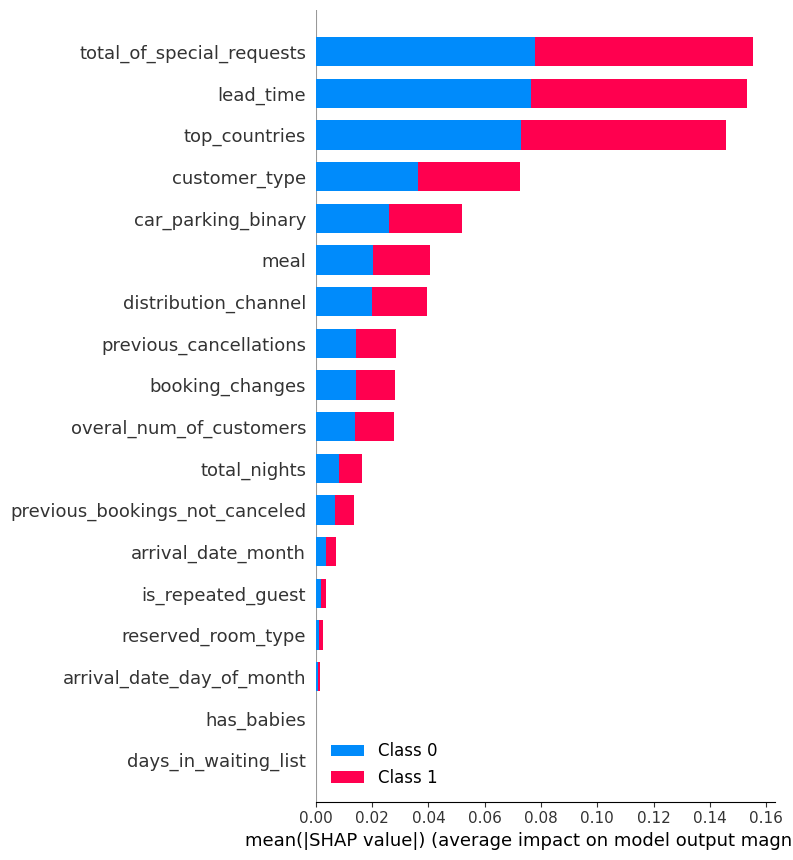

In [103]:
explainer = shap.Explainer(best_model_decision_tree, features_test_t)
shap_values = explainer(features_test_t)
shap_test = shap.Explainer(best_model_decision_tree).shap_values(features_test_t)
shap.summary_plot(shap_test, features_test_t,
                      max_display=25)

We see here that the model has determined an increase in the probability of cancellation of the reservation if the customer is from the PRT country. Let's check it on the dataframe

In [105]:
test[test['country'] == 'PRT']['is_canceled'].value_counts()

is_canceled
0    3411
1    2019
Name: count, dtype: int64

Indeed, customers from this country often cancel their reservations

Next, it makes sense to recall the decision tree that we displayed earlier

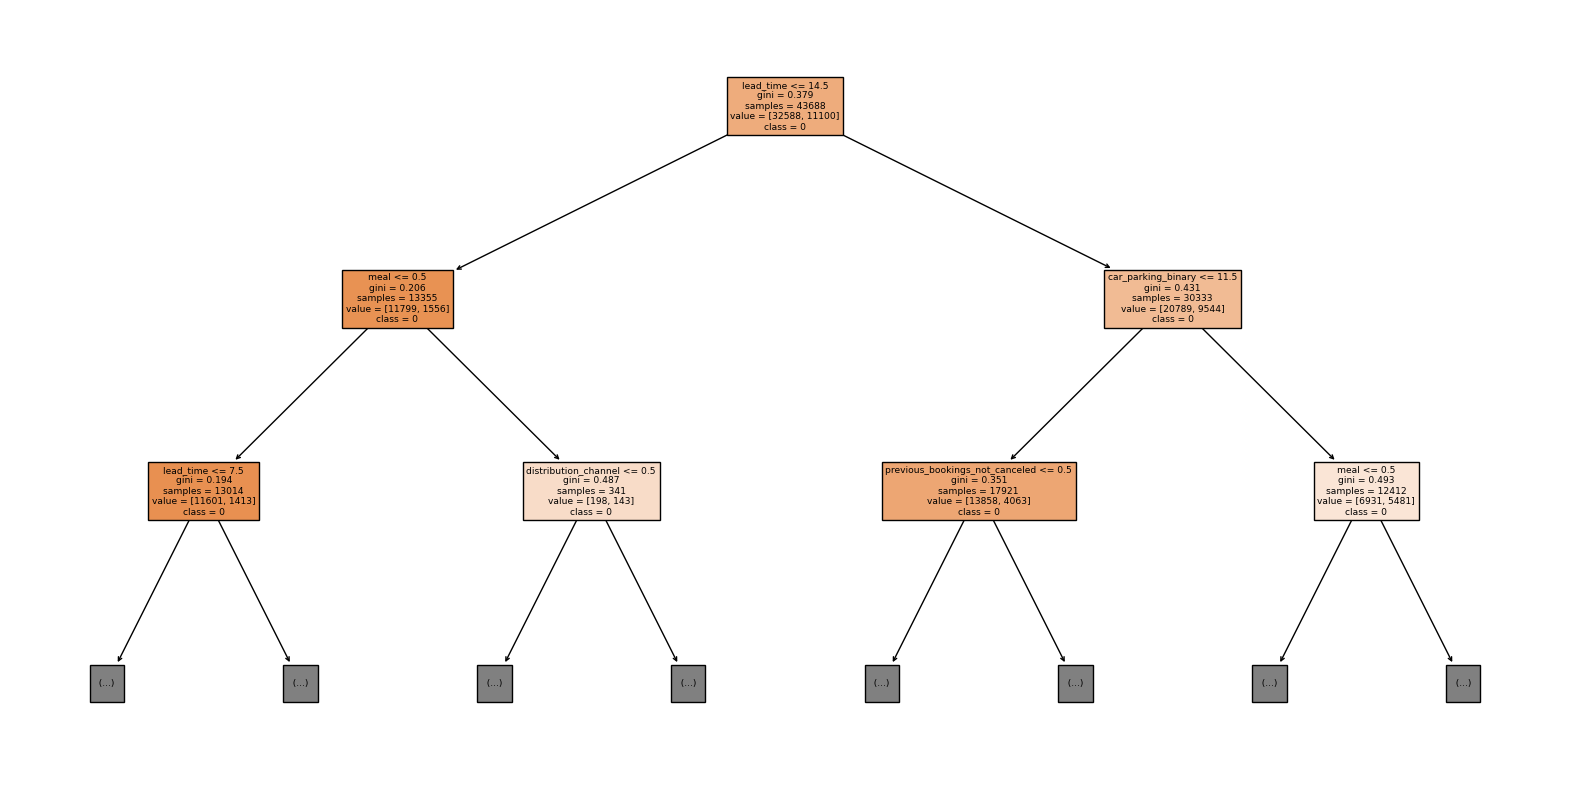

In [106]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(best_model_decision_tree, 
                   feature_names=features_test.columns,  
                   class_names=['0', '1'],
                   filled=True, max_depth=2)

Let's check the relationship between the number of special requests and the frequency of cancellation

In [107]:
test.groupby('total_of_special_requests').agg({'is_canceled': 'mean'})

is_canceled
total_of_special_requests             
0                             0.372875
1                             0.278317
2                             0.259605
3                             0.165269
4                             0.115044
5                             0.058824

#### Conclusion by step 5

Judging by this tree, customers with a PRT passport with the number of days from the booking date to the arrival date of more than 15 days who previously canceled the reservation are most likely to cancel the reservation. Also, if the client did not have special requests, then the probability of cancellation increases.

### Step 6. Write the general conclusion

Step 1

    1.1. Installed and imported the necessary libraries.
    
    1.2. Saved the training and test dataframes to variables
    
Step 2

    2.1. Checked the completeness of the data. No emissions were detected.
    
    2.2. The test sample is about 33% of all data
    
    2.3. Built histograms and barplots for the available features
    
    2.4. I checked the dependencies between the data using the phik library. After checking, I decided to delete several features. A high correlation of the target with the customer id was observed. There were also problems with arrival_date_year, which I later deleted from the dataframe.
    
Step 3

    3.1. Set the function for calculating profit. 
    
    3.2. Calculated to arrive in the current state. I applied boostrap for a 95% confidence interval of profit. I received a range from 34.08 to 35.52 million rubles.
    
Step 4
    
    4.1. Converted the data using OHE and ordinal encoding. I removed the features that correlated most with others.
    
    4.2. Trained decision tree models, random forest, logistic regression. The best F1 metric was shown by the decision tree model. I also tried using roc-auc as a metric, but I didn't see much difference.
    
    4.3. Set a function for calculating profit taking into account the predicted values. 
    
    4.4. Using boostrap, I estimated a 95% confidence interval of profit for each model. The best result came from the logistic regression model
    
    4.5. Calculated the possible profit under the ideal scenario, in which the model would predict everything correctly. 
    
    4.6. I took 400 thousand for the development of the model. With this in mind, I obtained the final values of the economic effect of predicting potential cancellations
    
    4.7. In total, I propose to use the decision tree model, which will bring a profit of 2.4 million rubles. during the test period
    
    
Step 5

    5.1. I tried to describe the portrait of the customer canceling the room reservation. 
    As a result, the description turned out as follows: most often, customers with a PRT passport with the number of days from the booking date to the arrival date of more than 25 days, who previously canceled the reservation, cancel the reservation. Also, if the client did not have special requests, then the probability of cancellation increases.